In [2]:
!pip install -q patool pyunpack

Imports

In [3]:
import os
import pyunpack
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Flatten, Conv2D, BatchNormalization, Dropout, Activation, MaxPool2D
from keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint


Extract Zipfile

In [4]:
!pwd

/content


In [5]:
rar_file = 'data.rar'
os.makedirs('/content/data', exist_ok= True)
extract_dir = '/content/data'

# extract train and test data from data.rar
#pyunpack.Archive(rar_file).extractall(extract_dir)

# remove the file data.rar
try :
  os.remove('data.rar')   
  print('Zip file removed')
except :
  None  


Data Loading

In [6]:
data_path = '/content/data'
train_path = os.path.join(data_path, 'train') 
test_path = os.path.join(data_path, 'test')

classes = os.listdir(train_path)
print(classes)

['disgust', 'sad', 'angry', 'happy', 'fear', 'surprise', 'neutral']


In [7]:
def get_data_generator(path, mode , img_size, batch_size) :
  generator = ImageDataGenerator(horizontal_flip=True)
  if mode == 'train' :
    train_generator = generator.flow_from_directory(path, target_size = (img_size, img_size),
                                                  batch_size=batch_size, class_mode='categorical', 
                                                  color_mode = 'grayscale', shuffle = True)
    return train_generator
  
  else :
    test_generator = generator.flow_from_directory(path, target_size = (img_size, img_size),
                                                  batch_size=batch_size, class_mode='categorical', 
                                                  color_mode = 'grayscale', shuffle = False)
    return test_generator

In [8]:
batch_size = 64
img_size = 48
train_generator = get_data_generator(train_path, 'train', batch_size, img_size)
test_generator = get_data_generator(test_path, 'test', batch_size, img_size)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Text(0.5, 1.0, 'Class VS Number-Of-Images')

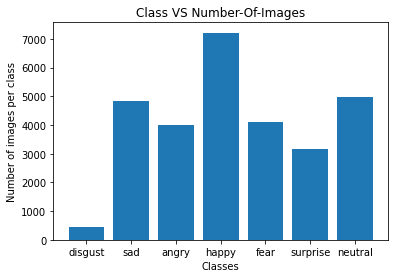

In [9]:
# number of images per class
class_img_num = []
for class_name in classes :
  class_dir = os.path.join(train_path, class_name)
  class_img_num.append(len(os.listdir(class_dir)))

plt.bar(classes, class_img_num)
plt.xlabel('Classes')
plt.ylabel('Number of images per class')
plt.title('Class VS Number-Of-Images')

In [10]:
samples = train_generator.next()
images, labels = samples[0], samples[1]

In [11]:
class2idx = train_generator.class_indices
idx2class = {idx : name for name, idx in class2idx.items()}

In [12]:
# plotting sample from each class 
def plot_sampels(num_classes, images, labels, class_indices) :
  img_size = images[0].shape[0]
  fig = plt.figure(figsize=(25,4))
  for idx in range(num_classes*2) :
     ax = fig.add_subplot(2, num_classes, idx+1, xticks = [], yticks = [])
     image = images[idx].reshape((img_size, img_size))
     ax.imshow(image, cmap='gray')
     title_idx = np.argmax(labels[idx])
     ax.set_title(class_indices[title_idx])
     #plt.show()

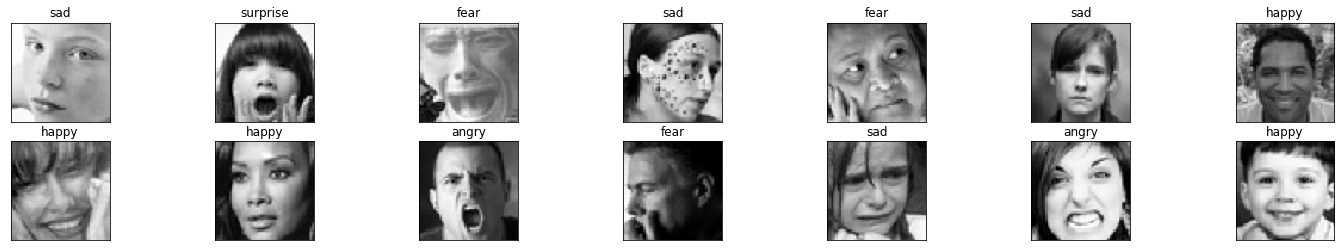

In [13]:
plot_sampels(len(classes), images, labels, idx2class)

Model

In [19]:
def CNN_Model(input_shape, num_classes, learning_rate) :
  model = Sequential()

  # block_1
  model.add(Conv2D(64, 3, padding = 'same', input_shape = input_shape)) 
  #model.add(BatchNormalization()) 
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(rate = 0.25))

  # block_2
  model.add(Conv2D(128, 5, padding = 'same')) 
  model.add(BatchNormalization()) 
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(rate = 0.25))

  # block_3
  model.add(Conv2D(512, 3, padding = 'same')) 
  model.add(BatchNormalization()) 
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(rate = 0.25))

    # block_4
  model.add(Conv2D(512, 3, padding = 'same')) 
  model.add(BatchNormalization()) 
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(rate = 0.25))

  # Flatten
  model.add(Flatten())

  # 1st fully connected layer
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  # 2st fully connected layer
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  # Classification Layer
  model.add(Dense(num_classes, activation='softmax')) 
  
  # optimizer 
  optimizer = Adam(learning_rate = learning_rate)
  
  model.compile(optimizer = optimizer, loss = categorical_crossentropy,
                metrics = ['accuracy'])

  return model


In [20]:
model = CNN_Model(input_shape = images[0].shape, num_classes=len(classes), learning_rate=0.0005)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        640       
                                                                 
 activation_6 (Activation)   (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                      

Trainig and evaluation

In [21]:
def train_model(epochs, model) :
  steps_per_epoch = train_generator.n // train_generator.batch_size
  test_steps = test_generator.n // test_generator.batch_size

  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=2, min_lr=0.00001, mode='auto')

  checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                              save_weights_only=True, mode='max', verbose=1)

  callbacks = [ checkpoint, reduce_lr]

  history = model.fit(
      x = train_generator,
      steps_per_epoch = steps_per_epoch,
      epochs = epochs,
      validation_data = test_generator,
      validation_steps = test_steps,
      callbacks = callbacks
  )
  return history

In [22]:
epochs = 20
history = train_model(epochs = epochs, model = model)


Epoch 1/20
598/598 [==============================] - ETA: 0s - loss: 1.8539 - accuracy: 0.2832
Epoch 00001: saving model to model_weights.h5
598/598 [==============================] - 46s 74ms/step - loss: 1.8539 - accuracy: 0.2832 - val_loss: 1.7810 - val_accuracy: 0.3289 - lr: 5.0000e-04
Epoch 2/20
598/598 [==============================] - ETA: 0s - loss: 1.5180 - accuracy: 0.4133
Epoch 00002: saving model to model_weights.h5
598/598 [==============================] - 44s 73ms/step - loss: 1.5180 - accuracy: 0.4133 - val_loss: 1.4388 - val_accuracy: 0.4603 - lr: 5.0000e-04
Epoch 3/20
598/598 [==============================] - ETA: 0s - loss: 1.3294 - accuracy: 0.4937
Epoch 00003: saving model to model_weights.h5
598/598 [==============================] - 43s 73ms/step - loss: 1.3294 - accuracy: 0.4937 - val_loss: 1.2569 - val_accuracy: 0.5221 - lr: 5.0000e-04
Epoch 4/20
598/598 [==============================] - ETA: 0s - loss: 1.2445 - accuracy: 0.5265
Epoch 00004: saving model to

In [23]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)